# E-commerce Customer Behavior Analytics
A comprehensive data science project analyzing customer purchasing patterns, segmentation, and predictive modeling for business insights

## Load Dataset and Initial Exploration

In [ ]:
# Install required packages
%pip install pandas numpy matplotlib seaborn scikit-learn


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score


In [3]:
# Load dataset
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vS597_KVD9wqThs6lDsxukLZHE0eNbHvMQiJN66H2PhU_CRJRIBX_0wT4LLJL8vhYm3deHV-XMMoBj9/pub?gid=284931259&single=true&output=csv')

In [4]:
# Quick look at the data
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nBasic statistics:")
print(df.describe())


First 5 rows:
   Customer ID  Gender  Age           City Membership Type  Total Spend  \
0          101  Female   29       New York            Gold      1120.20   
1          102    Male   34    Los Angeles          Silver       780.50   
2          103  Female   43        Chicago          Bronze       510.75   
3          104    Male   30  San Francisco            Gold      1480.30   
4          105    Male   27          Miami          Silver       720.40   

   Items Purchased  Average Rating  Discount Applied  \
0               14             4.6              True   
1               11             4.1             False   
2                9             3.4              True   
3               19             4.7             False   
4               13             4.0              True   

   Days Since Last Purchase Satisfaction Level  
0                        25          Satisfied  
1                        18            Neutral  
2                        42        Unsatisfied  
3

In [5]:
# Take a closer look at missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
Customer ID                 0
Gender                      0
Age                         0
City                        0
Membership Type             0
Total Spend                 0
Items Purchased             0
Average Rating              0
Discount Applied            0
Days Since Last Purchase    0
Satisfaction Level          2
dtype: int64


## Data Cleaning and Preprocessing

In [6]:
# Create a copy to avoid modifying original
df_clean = df.copy()

In [ ]:
# Fill missing values in 'Satisfaction Level' with the mode
df_clean["Satisfaction Level"] = df_clean["Satisfaction Level"].fillna(df_clean["Satisfaction Level"].mode()[0])

In [8]:
# Create additional features
print("Creating derived features...")

# Spending efficiency (spend per item)
df_clean['Spend Per Item'] = df_clean['Total Spend'] / (df_clean['Items Purchased'] + 1)  # +1 to avoid division by zero

# Customer value segments based on spend and frequency
df_clean['High Spender'] = (df_clean['Total Spend'] > df_clean['Total Spend'].quantile(0.75)).astype(int)
df_clean['Frequent Buyer'] = (df_clean['Items Purchased'] > df_clean['Items Purchased'].quantile(0.75)).astype(int)

# Recency categories
df_clean['Recency Category'] = pd.cut(df_clean['Days Since Last Purchase'],
                                      bins=[-1, 7, 30, 90, float('inf')],
                                      labels=['Very Recent', 'Recent', 'Moderate', 'Long Ago'])

# Age groups
df_clean['Age Group'] = pd.cut(df_clean['Age'],
                               bins=[0, 25, 35, 50, 100],
                               labels=['Young', 'Adult', 'Middle-aged', 'Senior'])

print(f"Dataset shape after preprocessing: {df_clean.shape}")
print("New features created: Spend Per Item, High Spender, Frequent Buyer, Recency Category, Age Group")

df_clean.head()

Creating derived features...
Dataset shape after preprocessing: (350, 16)
New features created: Spend Per Item, High Spender, Frequent Buyer, Recency Category, Age Group


,Customer ID,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level,Spend Per Item,High Spender,Frequent Buyer,Recency Category,Age Group
0,101,Female,29,New York,Gold,1120.20,14,4.6,True,25,Satisfied,74.680000,0,0,Recent,Adult
1,102,Male,34,Los Angeles,Silver,780.50,11,4.1,False,18,Neutral,65.041667,0,0,Recent,Adult
2,103,Female,43,Chicago,Bronze,510.75,9,3.4,True,42,Unsatisfied,51.075000,0,0,Moderate,Middle-aged
3,104,Male,30,San Francisco,Gold,1480.30,19,4.7,False,12,Satisfied,74.015000,1,1,Recent,Adult
4,105,Male,27,Miami,Silver,720.40,13,4.0,True,55,Unsatisfied,51.457143,0,0,Moderate,Adult


## Exploratory Data Analysis (EDA)

In [9]:
def perform_eda(df):    
    # Set up the plotting area
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('E-commerce Customer Behavior Analysis', fontsize=16, fontweight='bold')
    
    # 1. Age distribution
    axes[0,0].hist(df['Age'], bins=20, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Age Distribution')
    axes[0,0].set_xlabel('Age')
    axes[0,0].set_ylabel('Frequency')
    
    # 2. Total spend distribution
    axes[0,1].hist(df['Total Spend'], bins=20, alpha=0.7, color='lightgreen')
    axes[0,1].set_title('Total Spend Distribution')
    axes[0,1].set_xlabel('Total Spend')
    axes[0,1].set_ylabel('Frequency')
    
    # 3. Gender distribution
    gender_counts = df['Gender'].value_counts()
    axes[0,2].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', colors=['lightpink', 'lightblue'])
    axes[0,2].set_title('Gender Distribution')
    
    # 4. Membership type distribution
    membership_counts = df['Membership Type'].value_counts()
    axes[1,0].bar(membership_counts.index, membership_counts.values, color='coral')
    axes[1,0].set_title('Membership Type Distribution')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # 5. Satisfaction level distribution
    satisfaction_counts = df['Satisfaction Level'].value_counts()
    axes[1,1].bar(satisfaction_counts.index, satisfaction_counts.values, color='gold')
    axes[1,1].set_title('Satisfaction Level Distribution')
    
    # 6. Spend vs Items Purchased
    axes[1,2].scatter(df['Items Purchased'], df['Total Spend'], alpha=0.6, color='purple')
    axes[1,2].set_title('Total Spend vs Items Purchased')
    axes[1,2].set_xlabel('Items Purchased')
    axes[1,2].set_ylabel('Total Spend')
    
    # 7. Average Rating distribution
    axes[2,0].hist(df['Average Rating'], bins=15, alpha=0.7, color='orange')
    axes[2,0].set_title('Average Rating Distribution')
    axes[2,0].set_xlabel('Average Rating')
    axes[2,0].set_ylabel('Frequency')
    
    # 8. Days since last purchase
    axes[2,1].hist(df['Days Since Last Purchase'], bins=20, alpha=0.7, color='pink')
    axes[2,1].set_title('Days Since Last Purchase')
    axes[2,1].set_xlabel('Days')
    axes[2,1].set_ylabel('Frequency')
    
    # 9. Box plot of spending by gender
    bp = axes[2,2].boxplot([df[df['Gender']=='Male']['Total Spend'], 
                           df[df['Gender']=='Female']['Total Spend']], 
                          labels=['Male', 'Female'],
                          patch_artist=True,
                          widths=0.6)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightpink')
    axes[2,2].set_title('Total Spend by Gender')
    axes[2,2].set_xlabel('Gender')
    axes[2,2].set_ylabel('Total Spend ($)')
    axes[2,2].grid(False)

    
    plt.tight_layout()
    plt.show()
    
    # Additional insights
    print("\n📈 KEY INSIGHTS:")
    print(f"• Average customer age: {df['Age'].mean():.1f} years")
    print(f"• Average total spend: ${df['Total Spend'].mean():.2f}")
    print(f"• Average items purchased: {df['Items Purchased'].mean():.1f}")
    print(f"• Average rating: {df['Average Rating'].mean():.2f}")
    print(f"• Most common membership type: {df['Membership Type'].mode()[0]}")
    print(f"• Most common satisfaction level: {df['Satisfaction Level'].mode()[0]}")

/var/folders/_q/32lhyrps24z8dhvc999th6b80000gn/T/ipykernel_2775/114670266.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[2,2].boxplot([df[df['Gender']=='Male']['Total Spend'],


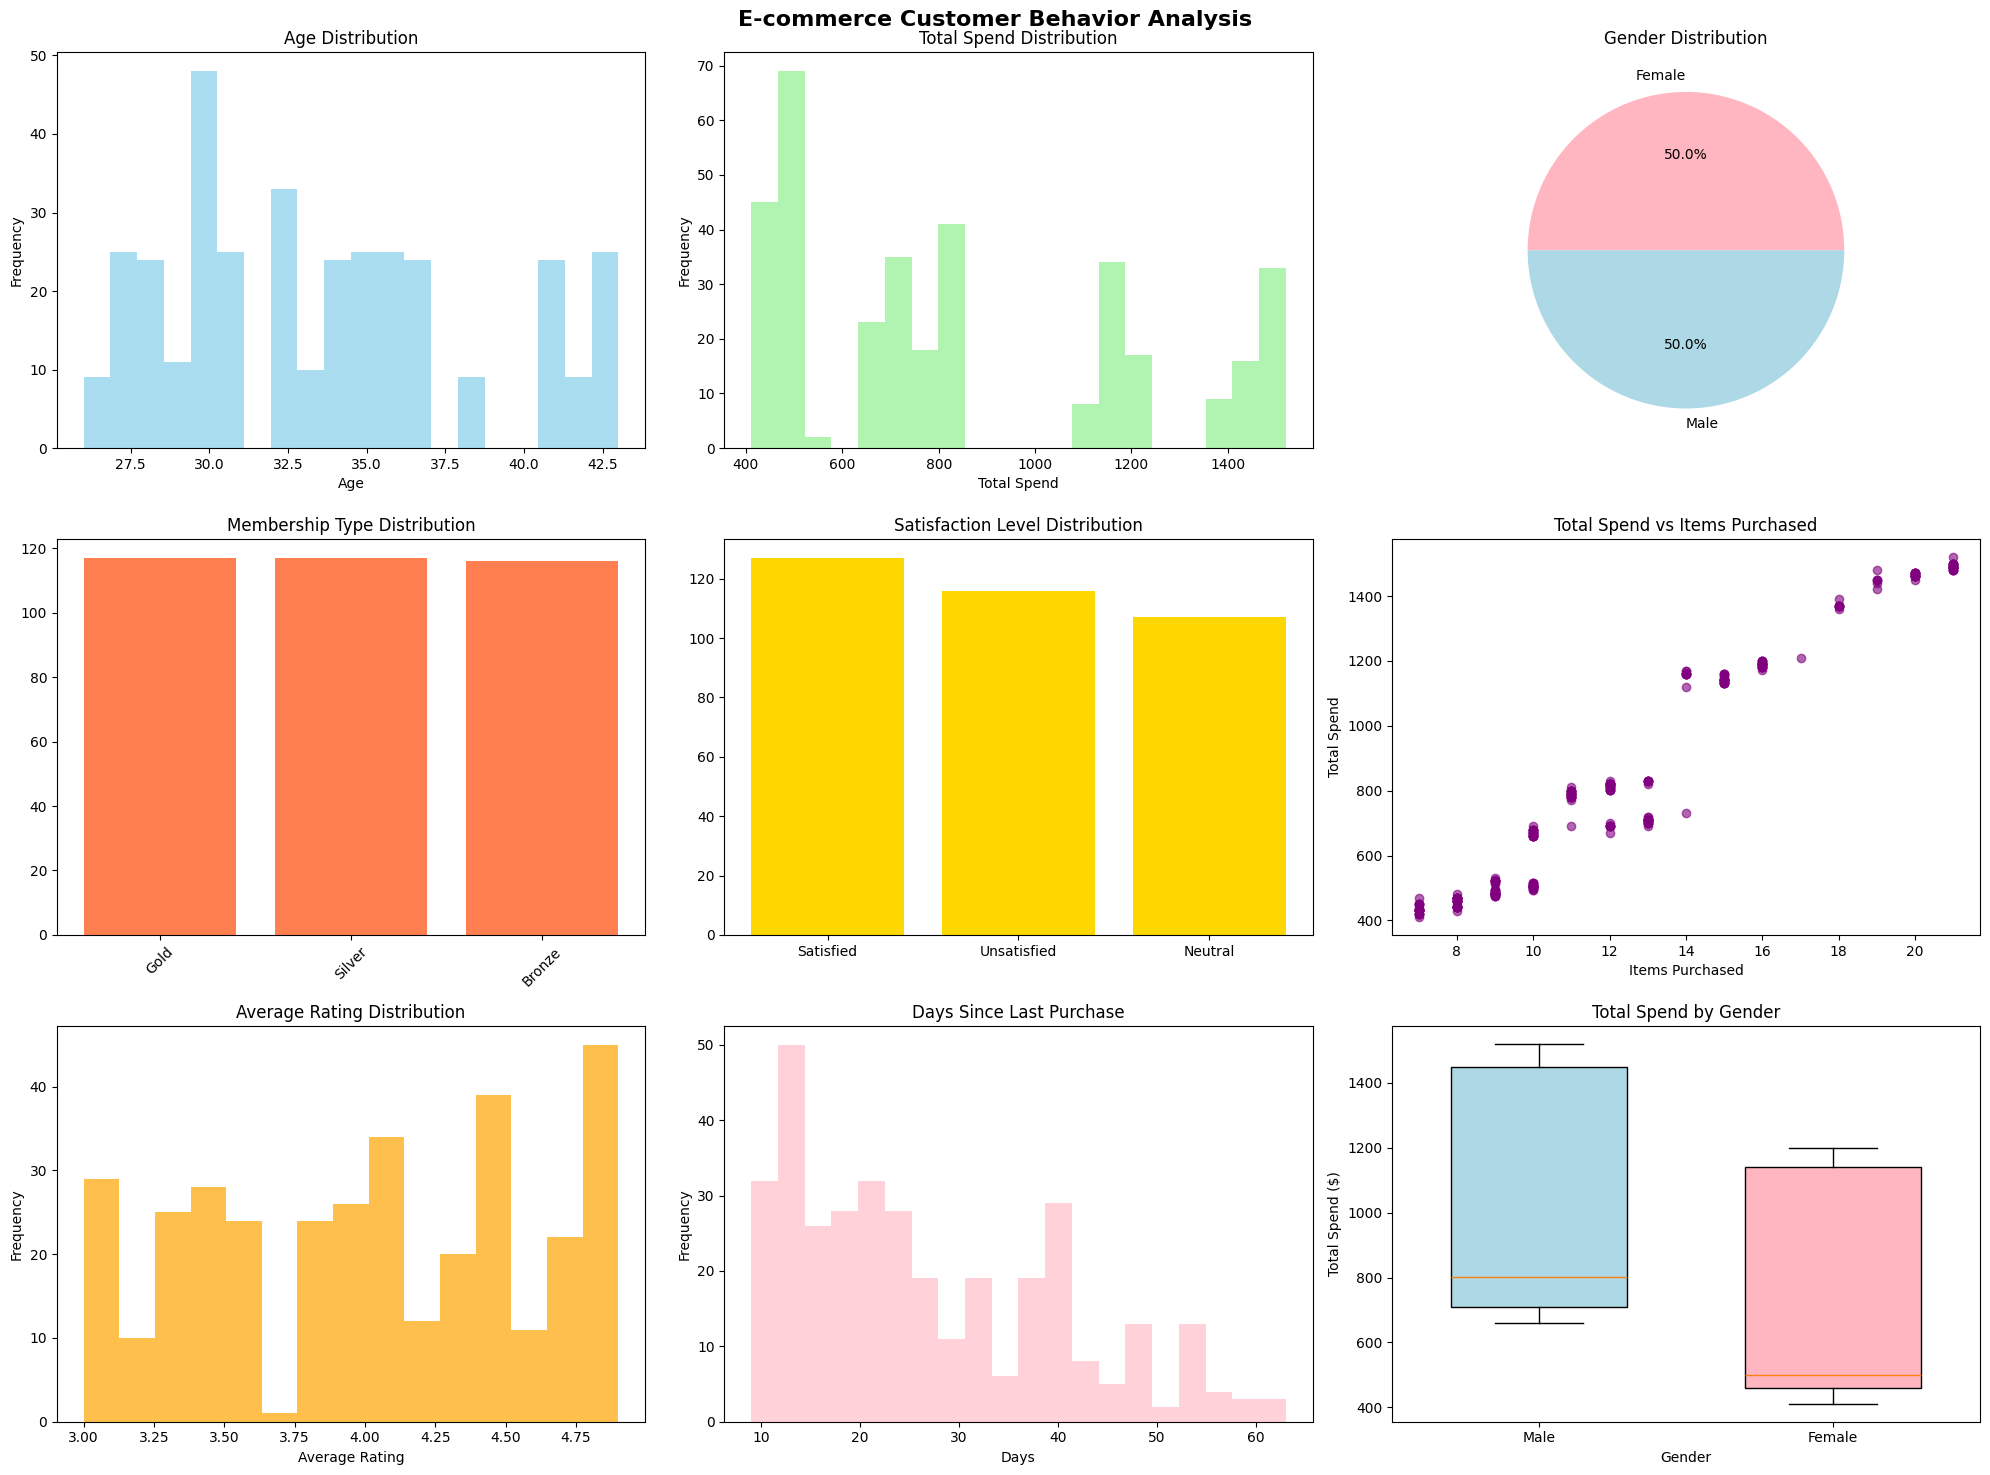


📈 KEY INSIGHTS:
• Average customer age: 33.6 years
• Average total spend: $845.38
• Average items purchased: 12.6
• Average rating: 4.02
• Most common membership type: Gold
• Most common satisfaction level: Satisfied


In [10]:
perform_eda(df_clean)

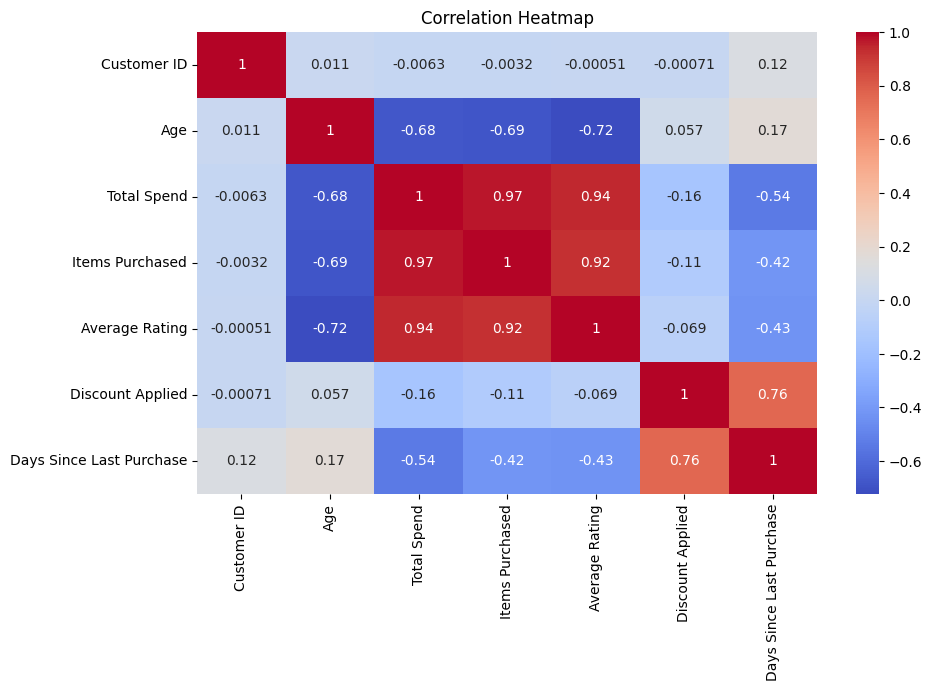

In [11]:
# Correlation heatmap of numeric variables
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


## Customer Segmentation
Perform customer segmentation using K-means clustering

In [13]:
def customer_segmentation(df):
    # Select features for clustering
    features_for_clustering = ['Age', 'Total Spend', 'Items Purchased', 
                              'Average Rating', 'Days Since Last Purchase']
    
    X_cluster = df[features_for_clustering].copy()
    
    # Standardize the features
    scaler = StandardScaler()
    X_cluster_scaled = scaler.fit_transform(X_cluster)
    
    # Find optimal number of clusters using elbow method
    inertias = []
    k_range = range(2, 11)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_cluster_scaled)
        inertias.append(kmeans.inertia_)
    
    # Plot elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertias, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    plt.show()
    
    # Perform clustering with optimal k (let's use 4)
    optimal_k = 4
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    df['Customer_Segment'] = kmeans.fit_predict(X_cluster_scaled)
    
    # Analyze segments
    print(f"\nCustomer segments created with k={optimal_k}")
    print("\nSegment Analysis:")
    segment_analysis = df.groupby('Customer_Segment')[features_for_clustering].mean()
    print(segment_analysis)
    
    # Visualize segments
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Customer Segments Analysis', fontsize=14, fontweight='bold')
    
    # Segment distribution
    segment_counts = df['Customer_Segment'].value_counts().sort_index()
    axes[0,0].bar(segment_counts.index, segment_counts.values, color='lightblue')
    axes[0,0].set_title('Customer Segment Distribution')
    axes[0,0].set_xlabel('Segment')
    axes[0,0].set_ylabel('Count')
    
    # Spend vs Items by segment
    for segment in df['Customer_Segment'].unique():
        segment_data = df[df['Customer_Segment'] == segment]
        axes[0,1].scatter(segment_data['Items Purchased'], segment_data['Total Spend'], 
                         label=f'Segment {segment}', alpha=0.7)
    axes[0,1].set_title('Total Spend vs Items Purchased by Segment')
    axes[0,1].set_xlabel('Items Purchased')
    axes[0,1].set_ylabel('Total Spend')
    axes[0,1].legend()
    
    # Age distribution by segment
    df.boxplot(column='Age', by='Customer_Segment', ax=axes[1,0])
    axes[1,0].set_title('Age Distribution by Segment')
    axes[1,0].set_xlabel('Customer Segment')
    
    # Rating by segment
    df.boxplot(column='Average Rating', by='Customer_Segment', ax=axes[1,1])
    axes[1,1].set_title('Average Rating by Segment')
    axes[1,1].set_xlabel('Customer Segment')
    
    plt.tight_layout()
    plt.show()
    
    return df

/Users/lena/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/lena/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/lena/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/lena/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/lena/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/lena/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/lena/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWar

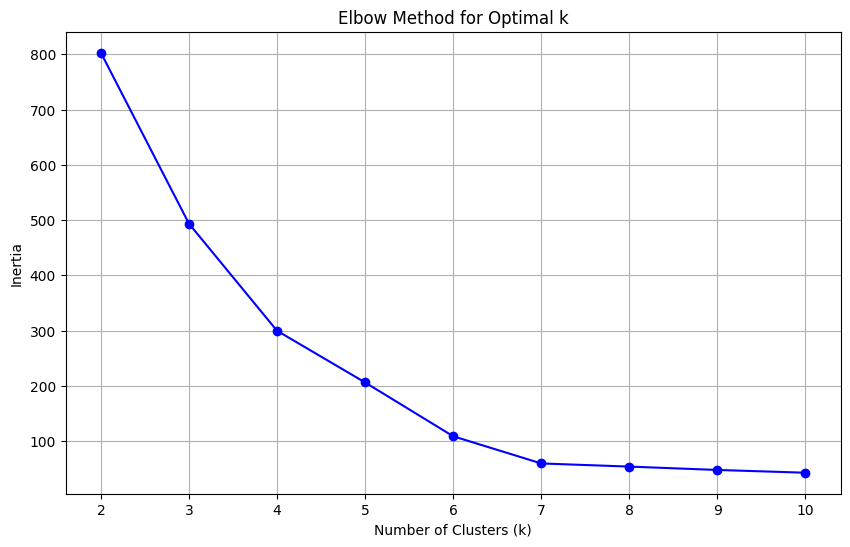

/Users/lena/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/lena/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/lena/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b



Customer segments created with k=4

Segment Analysis:
                        Age  Total Spend  Items Purchased  Average Rating  \
Customer_Segment                                                            
0                 28.948276   690.389655        11.637931        3.927586   
1                 29.152542  1455.549153        19.949153        4.808475   
2                 39.362069   473.388793         8.491379        3.325000   
3                 32.427350   983.337607        13.444444        4.354701   

                  Days Since Last Purchase  
Customer_Segment                            
0                                45.500000  
1                                11.288136  
2                                31.612069  
3                                19.948718  


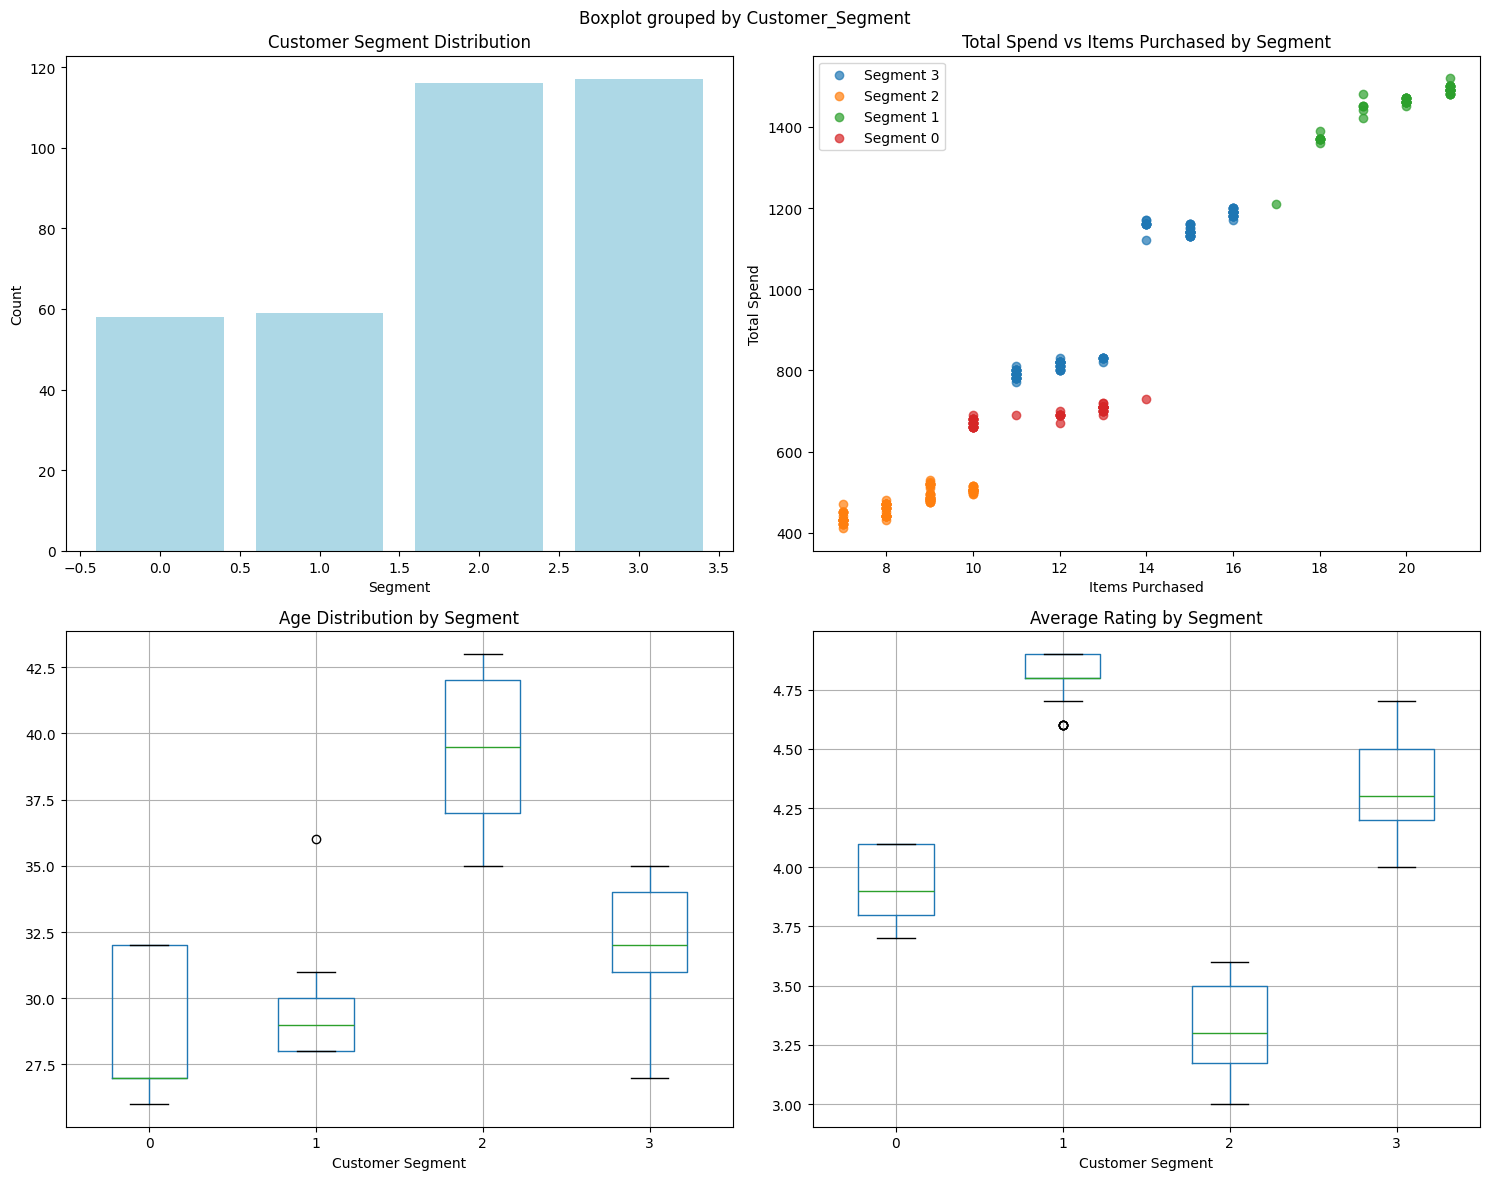

,Customer ID,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level,Spend Per Item,High Spender,Frequent Buyer,Recency Category,Age Group,Customer_Segment
0,101,Female,29,New York,Gold,1120.20,14,4.6,True,25,Satisfied,74.680000,0,0,Recent,Adult,3
1,102,Male,34,Los Angeles,Silver,780.50,11,4.1,False,18,Neutral,65.041667,0,0,Recent,Adult,3
2,103,Female,43,Chicago,Bronze,510.75,9,3.4,True,42,Unsatisfied,51.075000,0,0,Moderate,Middle-aged,2
3,104,Male,30,San Francisco,Gold,1480.30,19,4.7,False,12,Satisfied,74.015000,1,1,Recent,Adult,1
4,105,Male,27,Miami,Silver,720.40,13,4.0,True,55,Unsatisfied,51.457143,0,0,Moderate,Adult,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,446,Male,32,Miami,Silver,660.30,10,3.8,True,42,Unsatisfied,60.027273,0,0,Moderate,Adult,0
346,447,Female,36,Houston,Bronze,470.50,8,3.0,False,27,Neutral,52.277778,0,0,Recent,Middle-aged,2
347,448,Female,30,New York,Gold,1190.80,16,4.5,True,28,Satisfied,70.047059,1,1,Recent,Adult,3
348,449,Male,34,Los Angeles,Silver,780.20,11,4.2,False,21,Neutral,65.016667,0,0,Recent,Adult,3


In [14]:
customer_segmentation(df_clean)

## Predictive Modeling

In [ ]:
def predictive_modeling(df):
    # Prepare data for modeling
    df_model = df.copy()

    # Encode categorical variables
    le_gender = LabelEncoder()
    le_city = LabelEncoder()
    le_membership = LabelEncoder()
    
    df_model['Gender_Encoded'] = le_gender.fit_transform(df_model['Gender'])
    df_model['City_Encoded'] = le_city.fit_transform(df_model['City'])
    df_model['Membership_Encoded'] = le_membership.fit_transform(df_model['Membership Type'])
    
    # MODEL 1: Predict Customer Satisfaction Level
    print("\n📊 MODEL 1: CUSTOMER SATISFACTION PREDICTION")
    print("-" * 40)
    
    # Check unique values in satisfaction level
    print(f"Unique Satisfaction Levels: {df_model['Satisfaction Level'].unique()}")
    print(f"Satisfaction Level counts:\n{df_model['Satisfaction Level'].value_counts()}")
    
    features_satisfaction = ['Age', 'Gender_Encoded', 'City_Encoded', 'Membership_Encoded',
                           'Total Spend', 'Items Purchased', 'Average Rating', 
                           'Discount Applied', 'Days Since Last Purchase']
    
    # Ensure all feature columns exist and have no missing values
    missing_features = [col for col in features_satisfaction if col not in df_model.columns]
    if missing_features:
        print(f"Warning: Missing feature columns: {missing_features}")
        features_satisfaction = [col for col in features_satisfaction if col in df_model.columns]
    
    X_satisfaction = df_model[features_satisfaction]
    y_satisfaction = df_model['Satisfaction Level']
    
    # Check for any remaining NaN values
    if X_satisfaction.isnull().any().any():
        print("Warning: Found NaN values in features. Filling with median/mode...")
        for col in X_satisfaction.columns:
            if X_satisfaction[col].dtype in ['int64', 'float64']:
                X_satisfaction[col].fillna(X_satisfaction[col].median(), inplace=True)
    
    if y_satisfaction.isnull().any():
        print("Warning: Found NaN values in target variable. This should not happen after cleaning.")
        y_satisfaction.fillna(y_satisfaction.mode()[0], inplace=True)
    
    # Split the data - remove stratify if there are issues
    try:
        X_train_sat, X_test_sat, y_train_sat, y_test_sat = train_test_split(
            X_satisfaction, y_satisfaction, test_size=0.2, random_state=42, stratify=y_satisfaction
        )
    except ValueError as e:
        print(f"Stratify failed: {e}. Using random split instead.")
        X_train_sat, X_test_sat, y_train_sat, y_test_sat = train_test_split(
            X_satisfaction, y_satisfaction, test_size=0.2, random_state=42
        )
    
    # Scale features
    scaler_sat = StandardScaler()
    X_train_sat_scaled = scaler_sat.fit_transform(X_train_sat)
    X_test_sat_scaled = scaler_sat.transform(X_test_sat)
    
    # Train Random Forest model
    rf_satisfaction = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_satisfaction.fit(X_train_sat_scaled, y_train_sat)
    
    # Predictions
    y_pred_sat = rf_satisfaction.predict(X_test_sat_scaled)
    
    # Evaluate
    accuracy_sat = accuracy_score(y_test_sat, y_pred_sat)
    print(f"Satisfaction Prediction Accuracy: {accuracy_sat:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test_sat, y_pred_sat))
    
    # Feature importance
    feature_importance_sat = pd.DataFrame({
        'feature': features_satisfaction,
        'importance': rf_satisfaction.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 5 Features for Satisfaction Prediction:")
    print(feature_importance_sat.head())
    
    # MODEL 2: Predict Total Spend
    print("\n💰 MODEL 2: TOTAL SPEND PREDICTION")
    print("-" * 40)
    
    features_spend = ['Age', 'Gender_Encoded', 'City_Encoded', 'Membership_Encoded',
                     'Items Purchased', 'Average Rating', 'Discount Applied', 
                     'Days Since Last Purchase']
    
    # Ensure all feature columns exist
    missing_features = [col for col in features_spend if col not in df_model.columns]
    if missing_features:
        print(f"Warning: Missing feature columns: {missing_features}")
        features_spend = [col for col in features_spend if col in df_model.columns]
    
    X_spend = df_model[features_spend]
    y_spend = df_model['Total Spend']
    
    # Check for any remaining NaN values
    if X_spend.isnull().any().any():
        print("Warning: Found NaN values in features. Filling with median...")
        for col in X_spend.columns:
            if X_spend[col].dtype in ['int64', 'float64']:
                X_spend[col].fillna(X_spend[col].median(), inplace=True)
    
    if y_spend.isnull().any():
        print("Warning: Found NaN values in target variable. Filling with median...")
        y_spend.fillna(y_spend.median(), inplace=True)
    
    # Split the data
    X_train_spend, X_test_spend, y_train_spend, y_test_spend = train_test_split(
        X_spend, y_spend, test_size=0.2, random_state=42
    )
    
    # Scale features
    scaler_spend = StandardScaler()
    X_train_spend_scaled = scaler_spend.fit_transform(X_train_spend)
    X_test_spend_scaled = scaler_spend.transform(X_test_spend)
    
    # Train Random Forest model
    rf_spend = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_spend.fit(X_train_spend_scaled, y_train_spend)
    
    # Predictions
    y_pred_spend = rf_spend.predict(X_test_spend_scaled)
    
    # Evaluate
    mse_spend = mean_squared_error(y_test_spend, y_pred_spend)
    r2_spend = r2_score(y_test_spend, y_pred_spend)
    rmse_spend = np.sqrt(mse_spend)
    
    print(f"Total Spend Prediction RMSE: ${rmse_spend:.2f}")
    print(f"Total Spend Prediction R²: {r2_spend:.3f}")
    
    # Feature importance
    feature_importance_spend = pd.DataFrame({
        'feature': features_spend,
        'importance': rf_spend.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 5 Features for Spend Prediction:")
    print(feature_importance_spend.head())
    
    # Visualize model performance
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Satisfaction model - confusion matrix
    cm_sat = confusion_matrix(y_test_sat, y_pred_sat)
    sns.heatmap(cm_sat, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Satisfaction Prediction - Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    
    # Spend model - actual vs predicted
    axes[1].scatter(y_test_spend, y_pred_spend, alpha=0.6)
    axes[1].plot([y_test_spend.min(), y_test_spend.max()], 
                [y_test_spend.min(), y_test_spend.max()], 'r--', lw=2)
    axes[1].set_title('Total Spend: Actual vs Predicted')
    axes[1].set_xlabel('Actual Total Spend')
    axes[1].set_ylabel('Predicted Total Spend')
    
    plt.tight_layout()
    plt.show()
    
    return rf_satisfaction, rf_spend, scaler_sat, scaler_spend


📊 MODEL 1: CUSTOMER SATISFACTION PREDICTION
----------------------------------------
Unique Satisfaction Levels: ['Satisfied' 'Neutral' 'Unsatisfied']
Satisfaction Level counts:
Satisfaction Level
Satisfied      127
Unsatisfied    116
Neutral        107
Name: count, dtype: int64
Satisfaction Prediction Accuracy: 0.986

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.96      1.00      0.98        22
   Satisfied       1.00      0.96      0.98        25
 Unsatisfied       1.00      1.00      1.00        23

    accuracy                           0.99        70
   macro avg       0.99      0.99      0.99        70
weighted avg       0.99      0.99      0.99        70


Top 5 Features for Satisfaction Prediction:
                    feature  importance
4               Total Spend    0.238815
8  Days Since Last Purchase    0.198168
7          Discount Applied    0.144963
2              City_Encoded    0.141415
5           Items Purchased  

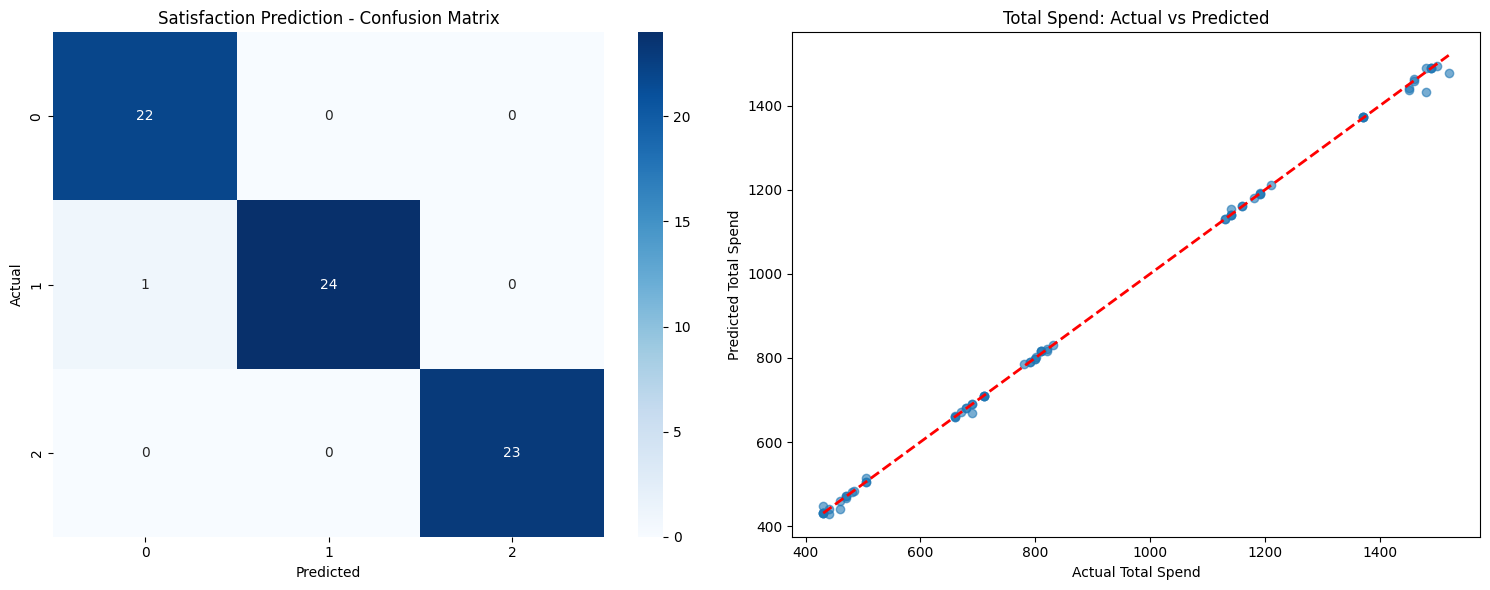

(RandomForestClassifier(random_state=42),
 RandomForestRegressor(random_state=42),
 StandardScaler(),
 StandardScaler())

In [16]:
predictive_modeling(df_clean)